# Fake News Detection using LSTM

Declaration: this approach is motivated by the FastAI course and I have used the library methods 
Steps followed:

Following steps are perforemd while preparing the data


1.   Downloading the data and loading the data in pandas dataframe
2.   Identification of missing values and replacing numerical values with median and the text values with NA
3.  Preparing the binary class label
4.  Using the FastAI approach first we will prepare a language model and then use transfer learning to train a classifier model
5  Accuracy Binary - ~64%
6  Accuracy 6 way - ~30%




In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## Preparing the data

### Import  Data

In [0]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/train2.tsv

--2019-08-10 09:26:27--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/train2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6969628 (6.6M) [text/plain]
Saving to: ‘train2.tsv.2’

train2.tsv.2        100%[===================>]   6.65M  29.2MB/s    in 0.2s    

2019-08-10 09:26:27 (29.2 MB/s) - ‘train2.tsv.2’ saved [6969628/6969628]



In [0]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/val2.tsv

--2019-08-10 09:26:29--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/val2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 863858 (844K) [text/plain]
Saving to: ‘val2.tsv.2’

val2.tsv.2          100%[===================>] 843.61K  --.-KB/s    in 0.1s    

2019-08-10 09:26:30 (5.54 MB/s) - ‘val2.tsv.2’ saved [863858/863858]



In [0]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/test2.tsv

--2019-08-10 09:26:32--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/test2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 869788 (849K) [text/plain]
Saving to: ‘test2.tsv.2’

test2.tsv.2         100%[===================>] 849.40K  --.-KB/s    in 0.1s    

2019-08-10 09:26:33 (5.62 MB/s) - ‘test2.tsv.2’ saved [869788/869788]



In [0]:
!wget https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/forbidden_words.txt

--2019-08-10 09:26:35--  https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/forbidden_words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 259 [text/plain]
Saving to: ‘forbidden_words.txt.2’

forbidden_words.txt 100%[===================>]     259  --.-KB/s    in 0s      

2019-08-10 09:26:35 (66.5 MB/s) - ‘forbidden_words.txt.2’ saved [259/259]



In [0]:
with open("forbidden_words.txt") as f: # Print forbidden words
  print(f.read())

misleading
truth
inaccurate
evidence
wrong
incorrect
true
fake
absurd
ridiculous
ridiculously
mistake
exaggerates
barely true
barely-true
mostly false
barely
mostly
claim
true
false
half-true
half true
truth
mostly-ture
mostly true
pants-on-fire
pants on fire


In [0]:
df_train = pd.read_csv("train2.tsv", sep="\t", header=None)

In [0]:
df_valid = pd.read_csv("val2.tsv", sep="\t", header=None)

In [0]:
df_test = pd.read_csv("test2.tsv", sep="\t", header=None)

In [0]:
df_train[3].values[:1]

array(['Says the Annies List political group supports third-trimester abortions on demand.'], dtype=object)

In [0]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


### Clean Data

In [0]:
df_cols = ['label', 'statement', 'subject', 'speaker', 'speaker\'s_job', 'state', 'party_affiliation', 
           'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context', 'justification']
# col 8 - 12 are historical counts for person

In [0]:
df_train = df_train.drop(columns=[0, 1]) ; df_train.columns = df_cols

In [0]:
df_valid = df_valid.drop(columns=[0, 1]) ; df_valid.columns = df_cols

In [0]:
df_test = df_test.drop(columns=[0, 1]) ; df_test.columns = df_cols

In [0]:
df_train['subject'].fillna("NA", inplace = True)
df_valid['subject'].fillna("NA", inplace = True)
df_test['subject'].fillna("NA", inplace = True)

df_train['speaker'].fillna("NA", inplace = True)
df_valid['speaker'].fillna("NA", inplace = True)
df_test['speaker'].fillna("NA", inplace = True)

df_train['speaker\'s_job'].fillna("NA", inplace = True)
df_valid['speaker\'s_job'].fillna("NA", inplace = True)
df_test['speaker\'s_job'].fillna("NA", inplace = True)

df_train['party_affiliation'].fillna("NA", inplace = True)
df_valid['party_affiliation'].fillna("NA", inplace = True)
df_test['party_affiliation'].fillna("NA", inplace = True)

df_train['context'].fillna("NA", inplace = True)
df_valid['context'].fillna("NA", inplace = True)
df_test['context'].fillna("NA", inplace = True)

df_train['state'].fillna("NA", inplace = True)
df_valid['state'].fillna("NA", inplace = True)
df_test['state'].fillna("NA", inplace = True)


df_train['justification'].fillna("NA", inplace = True)
df_valid['justification'].fillna("NA", inplace = True)
df_test['justification'].fillna("NA", inplace = True)

df_train['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_valid['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_test['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)


df_train['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_valid['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)
df_test['barely_true'].fillna(df_train['barely_true'].median(), inplace = True)


df_train['false'].fillna(df_train['false'].median(), inplace = True)
df_valid['false'].fillna(df_train['false'].median(), inplace = True)
df_test['false'].fillna(df_train['false'].median(), inplace = True)

df_train['half_true'].fillna(df_train['half_true'].median(), inplace = True)
df_valid['half_true'].fillna(df_train['half_true'].median(), inplace = True)
df_test['half_true'].fillna(df_train['half_true'].median(), inplace = True)

df_train['mostly_true'].fillna(df_train['mostly_true'].median(), inplace = True)
df_valid['mostly_true'].fillna(df_train['mostly_true'].median(), inplace = True)
df_test['mostly_true'].fillna(df_train['mostly_true'].median(), inplace = True)

df_train['pants_on_fire'].fillna(df_train['pants_on_fire'].median(), inplace = True)
df_valid['pants_on_fire'].fillna(df_train['pants_on_fire'].median(), inplace = True)
df_test['pants_on_fire'].fillna(df_train['pants_on_fire'].median(), inplace = True)

df_train['reputation'] = df_train['false']*-2 + df_train['barely_true']*-1+df_train['pants_on_fire']*-3 + df_train['half_true'] + df_train['mostly_true']*2  
df_valid['reputation'] = df_valid['false']*-2 + df_valid['barely_true']*-1+df_valid['pants_on_fire']*-3 + df_valid['half_true'] + df_valid['mostly_true']*2
df_test['reputation'] = df_test['false']*-2 + df_test['barely_true']*-1+df_test['pants_on_fire']*-3 + df_test['half_true'] + df_test['mostly_true']*2




In [0]:
df_train[:3]

,label,statement,subject,speaker,speaker's_job,state,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification,reputation
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,-2.0
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",3.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,247.0


In [0]:
len(df_train) - df_train.count()

label                0
statement            0
subject              0
speaker              0
speaker's_job        0
state                0
party_affiliation    0
barely_true          0
false                0
half_true            0
mostly_true          0
pants_on_fire        0
context              0
justification        0
reputation           0
dtype: int64

In [0]:
len(df_valid) - df_valid.count()

label                0
statement            0
subject              0
speaker              0
speaker's_job        0
state                0
party_affiliation    0
barely_true          0
false                0
half_true            0
mostly_true          0
pants_on_fire        0
context              0
justification        0
reputation           0
dtype: int64

In [0]:
len(df_test) - df_test.count()

label                0
statement            0
subject              0
speaker              0
speaker's_job        0
state                0
party_affiliation    0
barely_true          0
false                0
half_true            0
mostly_true          0
pants_on_fire        0
context              0
justification        0
reputation           0
dtype: int64

In [0]:
df_valid[:1]

,label,statement,subject,speaker,speaker's_job,state,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification,reputation
0,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,"However, Hartzler was talking about the entire...",0


In [0]:
df_test[:1]

,label,statement,subject,speaker,speaker's_job,state,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification,reputation
0,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,"Meantime, engineering experts agree the wall w...",-56


#### Add Column for Binary Classification

In [0]:
df_train['label_binary'] = [True if x in ['true','mostly-true','half-true'] else False for x in df_train['label']] 
df_valid['label_binary'] = [True if x in ['true','mostly-true','half-true'] else False for x in df_valid['label']] 
df_test['label_binary'] = [True if x in ['true','mostly-true','half-true'] else False for x in df_test['label']] 

## Language model

### Prepare Data

In [0]:
bs=32

In [0]:
data_lm1 = TextLMDataBunch.from_df(path='./',train_df=df_train,valid_df=df_valid,test_df=df_test,
                                   text_cols=['speaker\'s_job','statement','subject','speaker','state','party_affiliation','justification','context']
                                  ,max_vocab=60000, min_freq=1, mark_fields=True, include_bos=True, include_eos=True,label_cols='label', bs=bs)

In [0]:
data_lm1.show_batch

<bound method DataBunch.show_batch of TextLMDataBunch;

Train: LabelList (10240 items)
x: LMTextList
xxbos xxfld 1 xxmaj state representative xxfld 2 xxmaj says the xxmaj annies xxmaj list political group supports third - trimester abortions on demand . xxfld 3 abortion xxfld 4 dwayne - bohac xxfld 5 xxmaj texas xxfld 6 republican xxfld 7 xxmaj that 's a premise that he fails to back up . xxmaj annie 's xxmaj list makes no bones about being comfortable with candidates who oppose further restrictions on late - term abortions . xxmaj then again , this year its backing two xxmaj house candidates who voted for more limits . xxfld 8 a mailer xxeos,xxbos xxfld 1 xxmaj state delegate xxfld 2 xxmaj when did the decline of coal start ? xxmaj it started when natural gas took off that started to begin in ( xxmaj president xxmaj george xxup w. ) xxmaj bushs administration . xxfld 3 energy , history , job - accomplishments xxfld 4 scott - surovell xxfld 5 xxmaj virginia xxfld 6 democrat xxfld 7 xxm

In [0]:
len(data_lm1.vocab.itos)

27776

In [0]:
data_lm1.train_ds[0][0]

Text xxbos xxfld 1 xxmaj state representative xxfld 2 xxmaj says the xxmaj annies xxmaj list political group supports third - trimester abortions on demand . xxfld 3 abortion xxfld 4 dwayne - bohac xxfld 5 xxmaj texas xxfld 6 republican xxfld 7 xxmaj that 's a premise that he fails to back up . xxmaj annie 's xxmaj list makes no bones about being comfortable with candidates who oppose further restrictions on late - term abortions . xxmaj then again , this year its backing two xxmaj house candidates who voted for more limits . xxfld 8 a mailer xxeos

In [0]:
data_lm1.save('data_lm.pkl')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/ML_Practice/AWD_LSTM/'

In [0]:
data_lm1.save(f'{root_path}data_lm.pkl')

In [0]:
data_lm = load_data(path=root_path, file='data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"restrictions on late - term abortions . xxmaj then again , this year its backing two xxmaj house candidates who voted for more limits . xxfld 8 a mailer xxeos xxbos xxfld 1 xxmaj state delegate xxfld 2 xxmaj when did the decline of coal start ? xxmaj it started when natural gas took off that started to begin in ( xxmaj president xxmaj george xxup w. ) xxmaj bushs"
1,"statement is accurate , as it properly notes that the negotiated bond sale process resulted in $ 770,000 in fees for xxmaj bank of xxmaj america and xxmaj merrill xxmaj lynch , without trying to tie the money directly to xxmaj sink . xxmaj scott is n't nearly as careful in his xxup tv ad . xxmaj sink did n't funnel $ 770,000 to xxmaj bank of xxmaj america ."
2,"coast xxmaj guard to patrol two lakes on the u.s.-mexico border . xxfld 3 crime , immigration xxfld 4 louie - gohmert xxfld 5 xxmaj texas xxfld 6 republican xxfld 7 xxmaj gonzalez said the xxmaj coast xxmaj guard already comes to the lake "" once in a while . . . not very often "" because , he speculated , of budgetary limits . xxmaj our sense : xxmaj"
3,"has already shuffled their administration . xxfld 8 a television ad xxeos xxbos xxfld 1 xxmaj liberal advocacy group xxfld 2 xxmaj the xxmaj paul xxmaj ryan budget proposal would privatize xxmaj medicare . xxfld 3 federal - budget , health - care , medicare xxfld 4 agenda - project xxfld 5 xxmaj new xxmaj york xxfld 6 none xxfld 7 xxmaj but "" privatization "" does not have to"
4,"xxfld 6 talk - show - host xxfld 7 xxmaj kaufman told usthat her reference to "" the cow "" was about xxmaj maddow -- the xxup msnbc commentator who played the clip of xxmaj kaufman . "" i endearingly call her xxmaj rachel xxmaj mad - cow , "" xxmaj kaufman said . xxmaj we found several news articles quoting xxmaj obama as saying exactly that and he 's"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

### Train Language Model

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


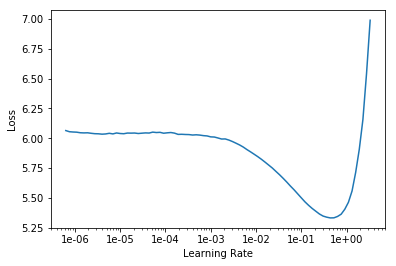

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7)) #Overfitting for 15 epochs changed to 3

epoch,train_loss,valid_loss,accuracy,time
0,3.679009,3.193678,0.416223,01:33
1,3.028853,3.048145,0.434388,01:33
2,2.762697,3.026173,0.438554,01:32


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (10240 items)
x: LMTextList
xxbos xxfld 1 xxmaj state representative xxfld 2 xxmaj says the xxmaj annies xxmaj list political group supports third - trimester abortions on demand . xxfld 3 abortion xxfld 4 dwayne - bohac xxfld 5 xxmaj texas xxfld 6 republican xxfld 7 xxmaj that 's a premise that he fails to back up . xxmaj annie 's xxmaj list makes no bones about being comfortable with candidates who oppose further restrictions on late - term abortions . xxmaj then again , this year its backing two xxmaj house candidates who voted for more limits . xxfld 8 a mailer xxeos,xxbos xxfld 1 xxmaj state delegate xxfld 2 xxmaj when did the decline of coal start ? xxmaj it started when natural gas took off that started to begin in ( xxmaj president xxmaj george xxup w. ) xxmaj bushs administration . xxfld 3 energy , history , job - accomplishments xxfld 4 scott - surovell xxfld 5 xxmaj virginia xxfld 6 democrat xxfld 7 xxmaj surovell said 

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


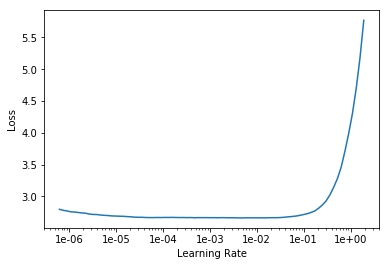

In [0]:
learn.recorder.plot()

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 5e-4, moms=(0.8,0.7)) # changed to 4

epoch,train_loss,valid_loss,accuracy,time
0,2.600205,2.995782,0.444228,01:51
1,2.503977,2.969896,0.450315,01:51
2,2.389786,2.972131,0.452371,01:51
3,2.292538,2.978339,0.452928,01:50


How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.save('fine_tuned')

In [10]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (10240 items)
x: LMTextList
xxbos xxfld 1 xxmaj state representative xxfld 2 xxmaj says the xxmaj annies xxmaj list political group supports third - trimester abortions on demand . xxfld 3 abortion xxfld 4 dwayne - bohac xxfld 5 xxmaj texas xxfld 6 republican xxfld 7 xxmaj that 's a premise that he fails to back up . xxmaj annie 's xxmaj list makes no bones about being comfortable with candidates who oppose further restrictions on late - term abortions . xxmaj then again , this year its backing two xxmaj house candidates who voted for more limits . xxfld 8 a mailer xxeos,xxbos xxfld 1 xxmaj state delegate xxfld 2 xxmaj when did the decline of coal start ? xxmaj it started when natural gas took off that started to begin in ( xxmaj president xxmaj george xxup w. ) xxmaj bushs administration . xxfld 3 energy , history , job - accomplishments xxfld 4 scott - surovell xxfld 5 xxmaj virginia xxfld 6 democrat xxfld 7 xxmaj surovell said 

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

#### Binary Classification

In [0]:
data_clas = TextClasDataBunch.from_df(path='./',train_df=df_train,valid_df=df_valid,test_df=df_test,
                                   text_cols=['speaker\'s_job','statement','subject','speaker','state','party_affiliation','justification','context']
                                  ,vocab =data_lm.train_ds.vocab, bs=bs,  mark_fields=True, include_bos=True, include_eos=True,label_cols='label_binary')

In [0]:
data_clas.save(f'{root_path}data_clas_binary.pkl')

In [0]:
data_clas = load_data(root_path, 'data_clas_binary.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
"xxbos xxfld 1 xxmaj president - xxmaj elect xxfld 2 xxmaj the wives of the 9 / 11 hijackers knew exactly what was happening and went back to xxmaj saudi xxmaj arabia two days before the attacks to watch their husbands on television flying the planes . xxfld 3 history , terrorism xxfld 4 donald - trump xxfld 5 xxmaj new xxmaj york xxfld 6 republican xxfld 7 xxmaj but",False
"xxbos xxfld 1 xxup u.s. xxmaj house of xxmaj representatives xxfld 2 xxmaj says the xxup u.s. xxmaj attorneys xxmaj office said that neither i nor my campaign had any idea what was going on regarding my fathers illegal campaign contributions . xxmaj and that s why they closed this case . xxfld 3 elections , legal - issues xxfld 4 ami - bera xxfld 5 xxmaj california xxfld 6",True
"xxbos xxfld 1 xxmaj state xxmaj assemblyman xxfld 2 xxmaj in 2011 , xxup nj economy ranked 47th -- at the bottom with xxmaj alabama , xxmaj mississippi xxmaj wyoming . xxmaj under xxmaj christie , xxup nj is falling behind . xxfld 3 economy xxfld 4 lou - greenwald xxfld 5 xxmaj new xxmaj jersey xxfld 6 democrat xxfld 7 xxmaj the graphic xxmaj honda used said that """,True
"xxbos xxfld 1 xxup na xxfld 2 xxmaj hospitals , doctors , mris , surgeries and so forth are more extensively used and far more expensive in this country than they are in many other countries . ' ' \t health - care \t mitt - romney \t xxmaj former governor \t xxmaj massachusetts \t republican \t 34 \t 32 \t 58 \t 33 \t 19 \t a xxmaj fox",True
"xxbos xxfld 1 xxmaj governor xxfld 2 xxmaj alex xxmaj sink funneled three quarters of a million dollars in no - bid contracts to xxmaj bank of xxmaj america . xxfld 3 economy , financial - regulation , message - machine xxfld 4 rick - scott xxfld 5 xxmaj florida xxfld 6 republican xxfld 7 xxmaj let 's take this one step at a time . xxmaj first , she",False


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


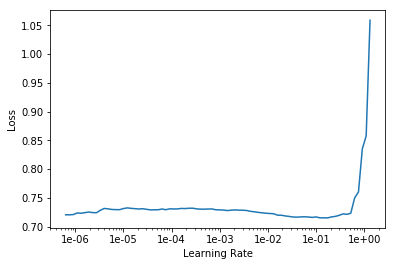

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.691896,0.684205,0.536604,00:39
1,0.680781,0.678267,0.566199,00:36
2,0.674103,0.669873,0.589564,00:38


In [0]:
learn.save('first_binary')

In [0]:
learn.load('first_binary')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (10240 items)
x: TextList
xxbos xxfld 1 xxmaj state representative xxfld 2 xxmaj says the xxmaj annies xxmaj list political group supports third - trimester abortions on demand . xxfld 3 abortion xxfld 4 dwayne - bohac xxfld 5 xxmaj texas xxfld 6 republican xxfld 7 xxmaj that 's a premise that he fails to back up . xxmaj annie 's xxmaj list makes no bones about being comfortable with candidates who oppose further restrictions on late - term abortions . xxmaj then again , this year its backing two xxmaj house candidates who voted for more limits . xxfld 8 a mailer xxeos,xxbos xxfld 1 xxmaj state delegate xxfld 2 xxmaj when did the decline of coal start ? xxmaj it started when natural gas took off that started to begin in ( xxmaj president xxmaj george xxup w. ) xxmaj bushs administration . xxfld 3 energy , history , job - accomplishments xxfld 4 scott - surovell xxfld 5 xxmaj virginia xxfld 6 democrat xxfld 7 xxmaj surovell said the d

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.669687,0.665083,0.587227,00:38
1,0.664230,0.635751,0.621495,00:41
2,0.647728,0.639715,0.631620,00:43
3,0.621918,0.640941,0.639408,00:42
4,0.597720,0.631021,0.634735,00:45
5,0.561352,0.640841,0.639408,00:46


In [0]:
learn.save('second_binary')

In [0]:
learn.load('second_binary');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.599524,0.637292,0.639408,01:22
1,0.545246,0.663387,0.628505,01:23


In [0]:
learn.save('third_binary')

In [0]:
learn.load('third_binary');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.481425,0.684968,0.640966,01:59


#### Multi Class Classification

In [0]:
data_clas = TextClasDataBunch.from_df(path='./',train_df=df_train,valid_df=df_valid,test_df=df_test,
                                   text_cols=['speaker\'s_job','statement','subject','speaker','state','party_affiliation','justification','context']
                                  ,vocab =data_lm.train_ds.vocab, bs=bs,  mark_fields=True, include_bos=True, include_eos=True,label_cols='label')

In [0]:
data_clas.save(f'{root_path}data_clas_multi.pkl')

In [0]:
data_clas = load_data(root_path, 'data_clas_multi.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
"xxbos xxfld 1 xxmaj president - xxmaj elect xxfld 2 xxmaj the wives of the 9 / 11 hijackers knew exactly what was happening and went back to xxmaj saudi xxmaj arabia two days before the attacks to watch their husbands on television flying the planes . xxfld 3 history , terrorism xxfld 4 donald - trump xxfld 5 xxmaj new xxmaj york xxfld 6 republican xxfld 7 xxmaj but",false
"xxbos xxfld 1 xxmaj presidential candidate xxfld 2 xxmaj in 2006 , xxmaj donald xxmaj trump was hoping for a real estate crash . xxfld 3 bankruptcy , candidates - biography , debt , economy , history , housing , income , jobs , stimulus , wealth xxfld 4 hillary - clinton xxfld 5 xxmaj new xxmaj york xxfld 6 democrat xxfld 7 xxmaj trump said , "" i do",mostly-true
"xxbos xxfld 1 xxmaj governor xxfld 2 i used tax cuts to help create over 80,000 jobs in xxmaj new xxmaj mexico . xxfld 3 taxes xxfld 4 bill - richardson xxfld 5 xxmaj new xxmaj mexico xxfld 6 democrat xxfld 7 xxmaj what 's worth noting is that , in all three stories xxmaj eisnaugle cited , the fraud was exposed . xxmaj the only real impact was that",mostly-true
"xxbos xxfld 1 xxmaj governor xxfld 2 xxmaj says the high - speed rail project provides short - term jobs . xxfld 3 jobs , stimulus , transportation xxfld 4 rick - scott xxfld 5 xxmaj florida xxfld 6 republican xxfld 7 xxmaj that was a lot of xxmaj supreme xxmaj court history . xxmaj first , lets review xxmaj obamas statement : "" xxmaj ultimately , i am confident",mostly-true
"xxbos xxfld 1 xxmaj retired social worker xxfld 2 xxmaj tea xxmaj party xxmaj congressman xxmaj frank xxmaj guinta voted for billions in cuts to veterans programs . xxfld 3 veterans xxfld 4 carol - shea - porter xxfld 5 xxmaj new xxmaj hampshire xxfld 6 democrat xxfld 7 xxmaj let 's go back to xxmaj scott 's statement . xxmaj he said , "" xxmaj when i walked into",barely-true


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


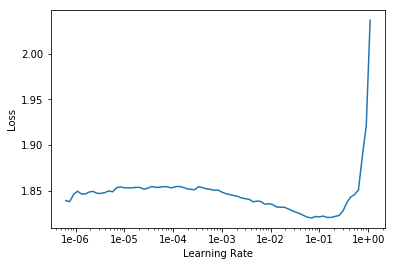

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.756586,1.737119,0.218847,00:44
1,1.750149,1.710425,0.241433,00:48
2,1.728786,1.694174,0.260903,00:51
3,1.710961,1.695300,0.246885,00:49


In [0]:
learn.save('first_multi')

In [0]:
learn.load('first_multi');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


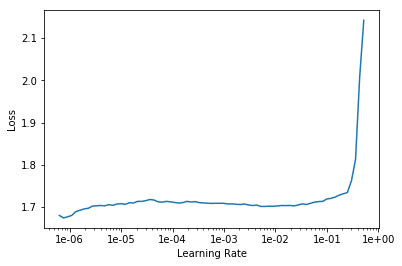

In [0]:
learn.recorder.plot()

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.724492,1.702828,0.254673,00:59
1,1.714408,1.714674,0.218847,00:56
2,1.693401,1.672788,0.270249,00:57
3,1.652109,1.665336,0.279595,00:58
4,1.590129,1.670797,0.293614,00:57
5,1.516503,1.681551,0.295950,00:56


In [0]:
learn.save('second_multi')

In [0]:
learn.load('second_multi');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.509567,1.693811,0.290498,01:30
1,1.499128,1.702553,0.285047,01:28
2,1.458177,1.710320,0.292056,01:26
3,1.457790,1.711189,0.291277,01:30


In [0]:
learn.save('third_multi')

In [0]:
learn.load('third_multi');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.470009,1.728713,0.291277,02:00
